In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import matplotlib as mpl
import xarray as xr
import numpy as np
import glob
import xesmf as xe
import pyremo as pr
from REMO2020_mod import modelclass, open_mfdataset, season_mean

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernel2023/share/proj failed


In [2]:
def plot(da, ax, transform=ccrs.PlateCarree(), projection=ccrs.PlateCarree(), vmin=None, vmax=None, norm=None, borders=True,xlocs=range(-180,180,10), ylocs=range(-90,90,10), extent=None, figsize=(15,10), title=''):
    """plot a domain using the right projections and transformations with cartopy"""
    #%matplotlib inline
    import cartopy.feature as cf

    ax.projection=projection
    if extent:
        ax.set_extent(extent, crs=projection)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      xlocs=xlocs, ylocs=ylocs, x_inline=False, y_inline=False)
    gl.xlines = True
    gl.ylines = True
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    gl.top_labels = False
    sbl = da.plot(ax=ax, norm=norm, cmap='jet', transform=transform, vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    if borders: ax.add_feature(cf.BORDERS)
    if borders: ax.add_feature(cf.LAKES.with_scale('50m'), facecolor='white',
        edgecolor='black', zorder=0)
    ax.set_title(title)
    return sbl

In [3]:
# define data paths
rdata = './data_in/model_data/'
aatsr_path = "./data_in/AOD/"
figpath = './figures/'

In [4]:
# Define year to be plotted (only one for illustrative purposes)
year = 2005

In [5]:
# define the runs to be plotted
modelruns =[] # init

modelruns.append(modelclass("036032","REMO MACv2-SP",True,varname='AOD'))
modelruns.append(modelclass("036034","REMO MERRA-2",True,varname='AOD'))
modelruns.append(modelclass("036005","REMO Tanre",False,varname='AOD'))

In [6]:
# Set halo zone length (will be cutted out)
halo = 8

In [7]:
# get model data
for obj in modelruns:
    # filenames
    pattern = rdata+"remo_results_"+obj.userexp+"/"+str(year)+"/e"+obj.userexp+"m*.nc"
    obj.filenames = glob.glob(pattern)
    obj.filenames.sort()
    # actual data
    ds = open_mfdataset(obj.filenames, parallel=False, chunks='auto')
    obj.vardiff = pr.parse_dates(ds[["AOD"]])
    obj.vardiff = season_mean(obj.vardiff.isel(rlat=slice(halo+1,obj.vardiff.sizes["rlat"]-halo+1), rlon=slice(halo+1,obj.vardiff.sizes["rlon"]-halo+1))).compute()
    if(obj.r2020file):
        pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude,ds.rotated_latitude_longitude.grid_north_pole_latitude)

/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [8]:
# open global AATRS satellite data
# define filenames and open data
filenames_aatsr = glob.glob(aatsr_path+str(year)+'*-C3S-L3_AEROSOL-AER_PRODUCTS-AATSR-ENVISAT-ensemble-MONTHLY-v2.9_withdate.nc')
filenames_aatsr.sort()
ds_aatsr = open_mfdataset(filenames_aatsr, parallel=False, chunks='auto')
# create seasonal means
aatsr_smean = season_mean(pr.parse_dates(ds_aatsr.AOD550))

In [9]:
# get lon/lat bounds for AATSR from first modelrun
lon_min = -16.0 # these are set manually to make the plot more comparable with REMO, np.min(modelruns[0].vardiff.lon.values)
lon_max = 46.0 # these are set manually to make the plot more comparable with REMO, np.max(modelruns[0].vardiff.lon.values)
lat_min = np.min(modelruns[0].vardiff.lat.values)
lat_max = np.max(modelruns[0].vardiff.lat.values)

In [10]:
# define season order and corresponding title
seasons = ["DJF","MAM","JJA","SON"]
seasonstitle = ["winter","spring","summer","autumn"]

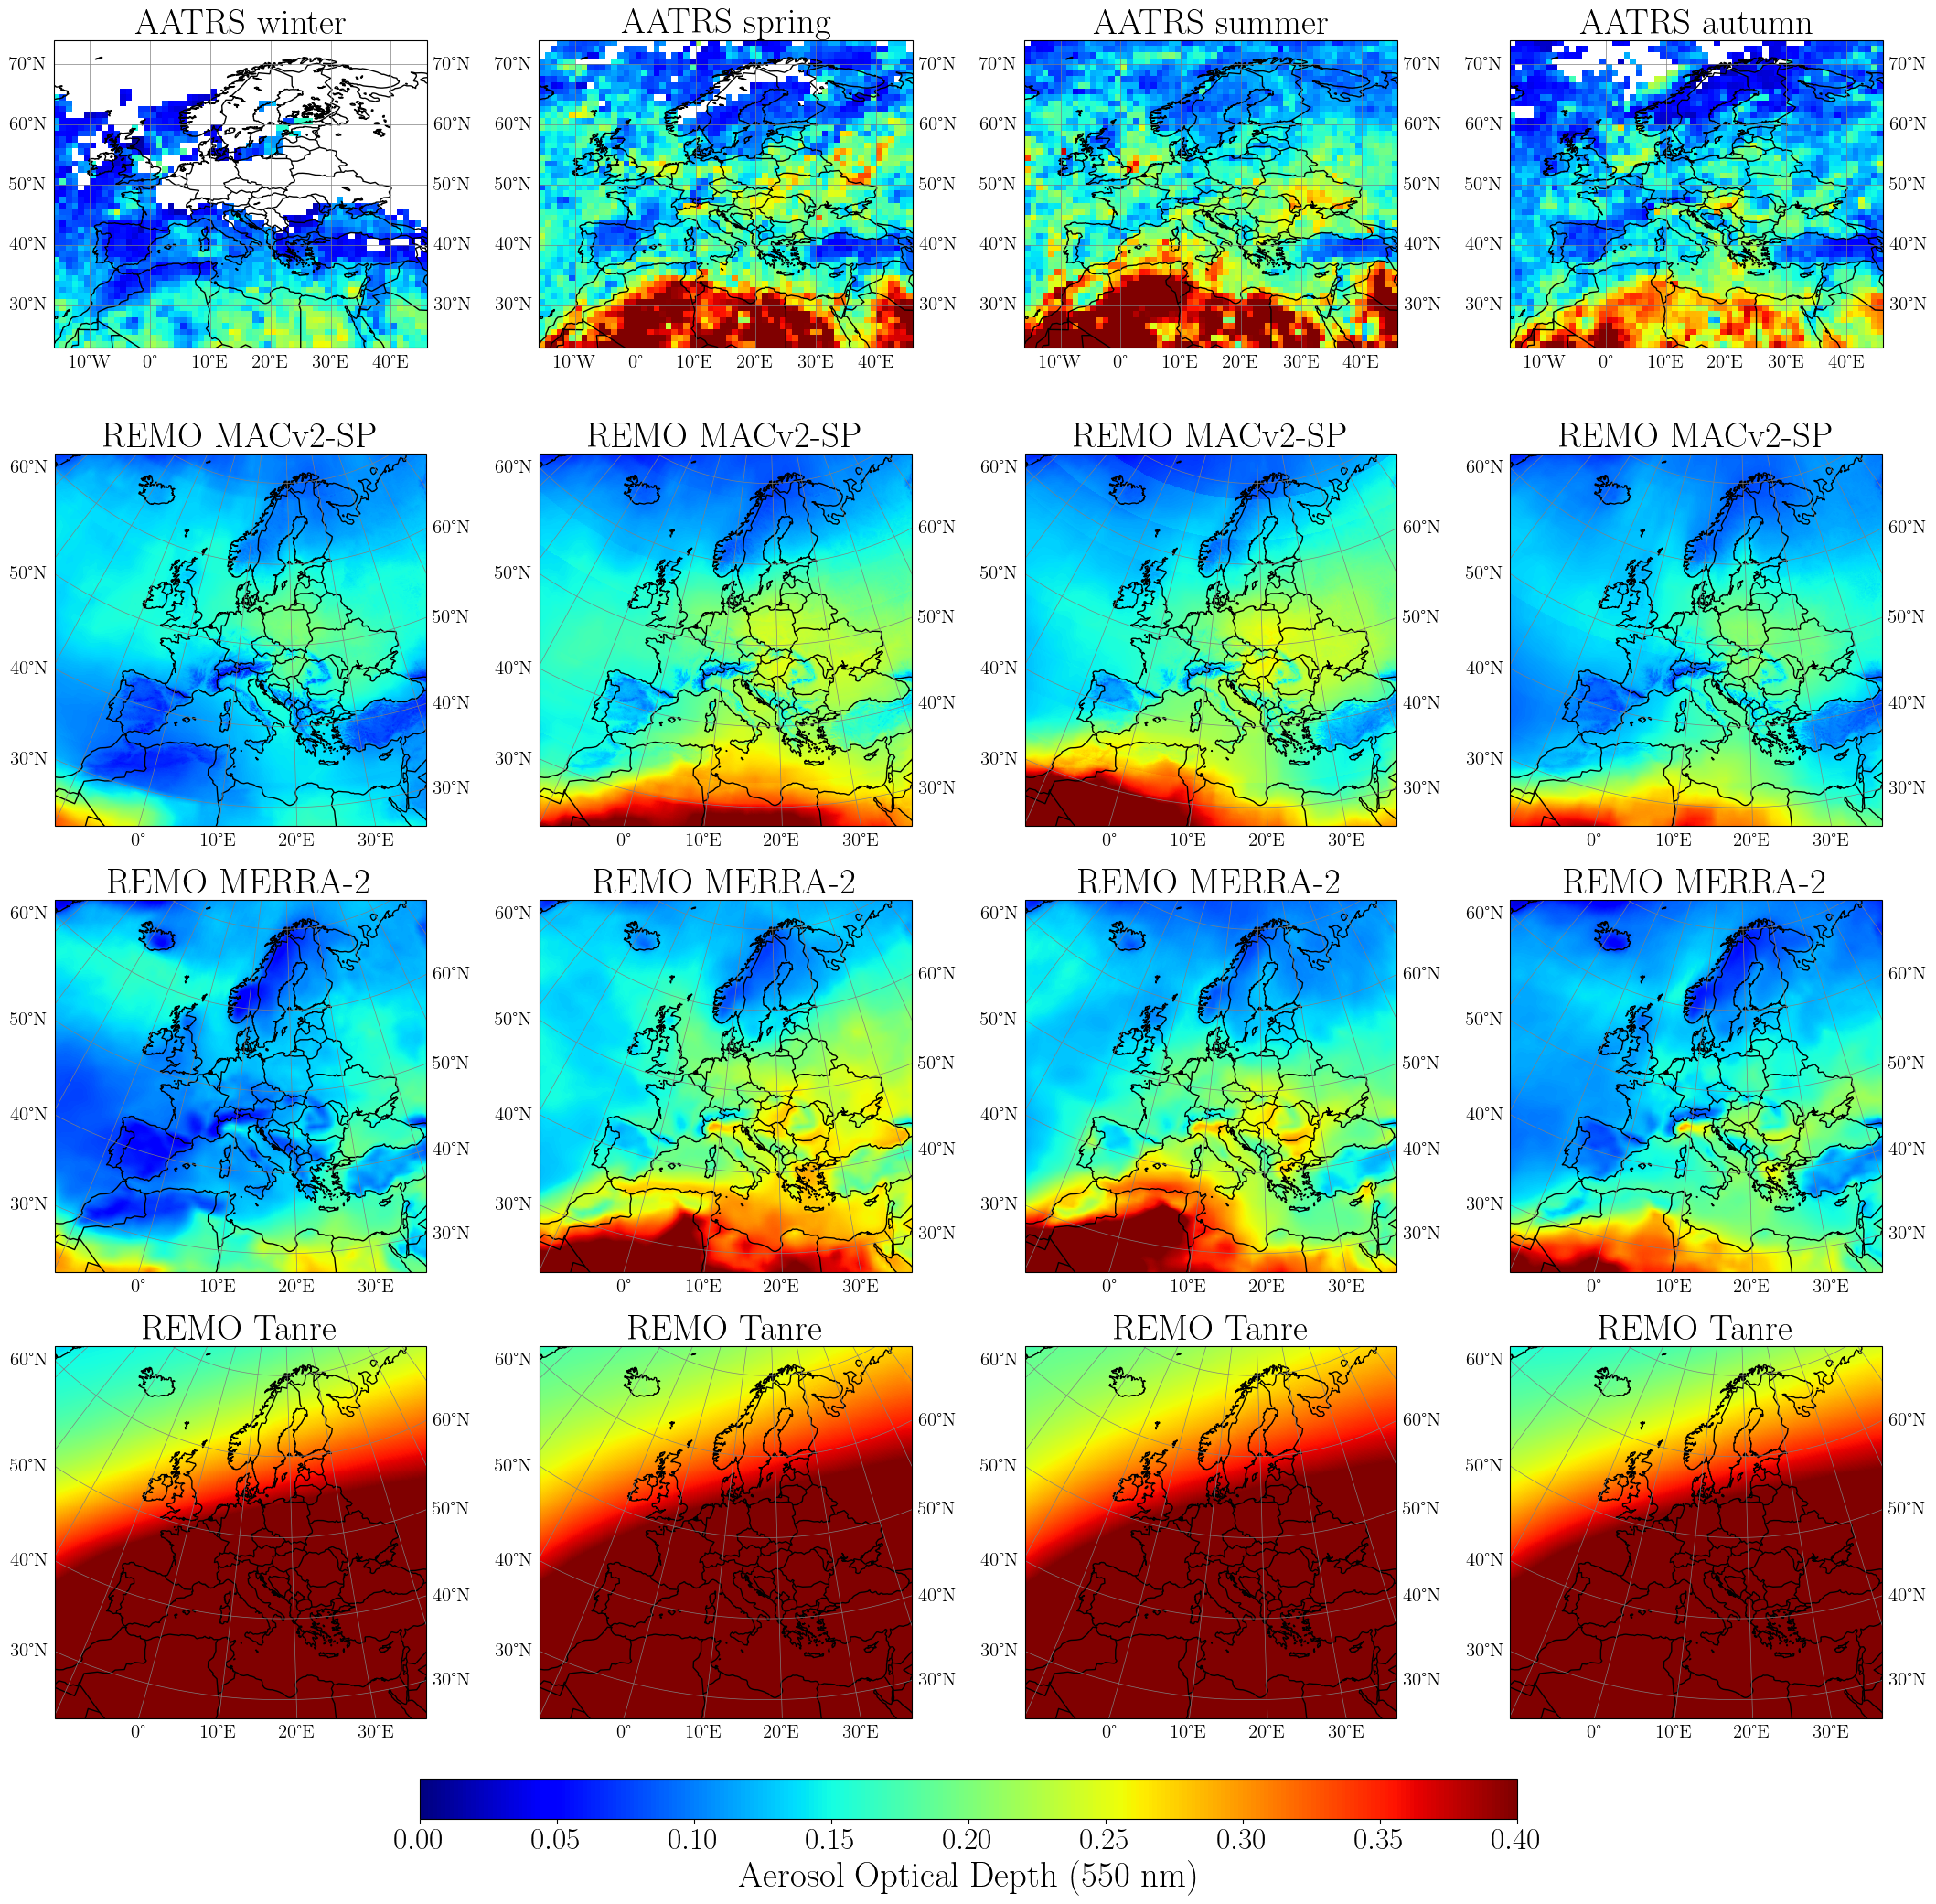

In [11]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# set default plot size larger for convenience
matplotlib.rcParams['figure.figsize'] = (20, 22)
# Bring title text closer to figure
matplotlib.rcParams['axes.titlepad'] = -0
plt.rcParams["figure.subplot.hspace"] = 0.2 # the amount of height reserved for white space between subplots
plt.rcParams["figure.subplot.wspace"] = 0.3 # the amount of height reserved for white space between subplots
plt.rcParams["axes.titlesize"] = 28
plt.rcParams['axes.labelsize'] = 22
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'
plt.rcParams["xtick.labelsize"] = 24
plt.rcParams["ytick.labelsize"] = 24
plt.rcParams["legend.fontsize"] = 28

# Open subplot
fig, ((ax)) = plt.subplots(nrows=4,ncols=4,subplot_kw={'projection': ccrs.RotatedPole(*pole)})
fig.subplots_adjust(bottom=0.15, top=1.0, left=0, right=1.0)

vmin = 0.
vmax = 0.4

norm =mpl.colors.Normalize(vmin, vmax) # determine colormap The maximum and minimum value of 

# add plots for aatsr
for iseas in range(len(seasons)):
    sbl = plot(aatsr_smean.sel(season=seasons[iseas]).sel(longitude=slice(lon_min,lon_max), latitude=slice(lat_min,lat_max)), ax[0,iseas], transform = ccrs.PlateCarree(), projection=ccrs.PlateCarree(), norm=norm,title="AATRS "+seasonstitle[iseas])
    jj = 1 # index for modelruns
    for obj in modelruns:
        sbl = plot(obj.vardiff.AOD.sel(season=seasons[iseas]), ax[jj,iseas], transform = ccrs.RotatedPole(*pole), projection=ccrs.RotatedPole(*pole), norm=norm,title=obj.runame)
        jj = jj + 1

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(sbl, cax=cbar_ax, norm=norm,cmap='jet',orientation='horizontal')
cbar.set_label('Aerosol Optical Depth (550 nm)', fontsize=28)
plt.savefig(figpath+'AOD_EU_sat_merra.png',format="png",bbox_inches='tight', pad_inches=0)